In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats

In [2]:
data_path = '../../data/tfidf_cos_kmeans/'

In [3]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [4]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [5]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
#     df = df[df.Kudos != 0]
#     df['Kudos'] = np.log(df['Kudos'])
#     df = df[df.Hits != 0]
#     df['Hits'] = np.log(df['Hits'])
#     df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
    df['Kudos'] = df['Kudos']/df['Chapters']
    df = df.dropna(subset=['Kudos'])
    df = df[np.isfinite(df['Kudos'])]
    df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)
    
    df = df.dropna(subset=['Comments'])
    df = df[np.isfinite(df['Comments'])]
    df['Comments'] = (df['Comments'] - df['Comments'].mean())/df['Comments'].std(ddof=0)

    return df

In [6]:
def create_dict(df, field, binsize):
    
    # Make bins
    df.Cos = df.Cos.astype(float)
    min_cos = min(df.Cos.tolist())
    max_cos = max(df.Cos.tolist())
    dic = {}
    for i in np.arange(min_cos, max_cos, binsize):
        df_s = df[(df.Cos >= i) & (df.Cos < i+binsize)]
#         if len(df_s) > 9:
#             print (min_cos, max_cos)
#             print(df_s[field].tolist())
        li = df_s[field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [11]:
def plot_agg(flist, title):
    df_all = []
    for i,fandom in enumerate(flist):
        df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
        df = create_normed_dfs(df)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[['Cos', 'Kudos']].dropna()
        df_all.append(df)
        
    df = pd.concat(df_all)
    df = df.sort_values(by = 'Cos')[5:-5]
    df = df.sort_values(by = 'Kudos')[5:-5]
    dic = create_dict(df, 'Kudos', 0.1)
    x = sorted(dic.keys())
    y = [dic[j][0] for j in x]
    
    print(dic)
    
    #     Make error bars
    lower_error = [dic[j][0]-dic[j][1] for j in x]
    upper_error = [dic[j][2]-dic[j][0] for j in x]
    asymmetric_error = [lower_error, upper_error]



    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.xlabel('Novelty',fontsize=15)
    plt.ylabel('Kudos (z-score)',fontsize=15)

    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.title(title)
    

{0.007449735602264584: (0.04720337419924968, 0.03820103615628616, 0.05508770762487703), 0.10744973560226459: (0.05930449661646972, 0.05386666213395827, 0.06531675339725938), 0.2074497356022646: (0.041664618074126115, 0.035356274727220985, 0.04802564726017411), 0.30744973560226463: (0.036142855081128925, 0.0287760835118707, 0.04366661630699738), 0.4074497356022646: (0.02691697685920323, 0.01847797186489173, 0.036551584952435726), 0.5074497356022646: (0.030111094706354362, 0.020704465161793695, 0.03939905863990905), 0.6074497356022647: (-0.002977159801291069, -0.01033963390988136, 0.0041782618649365355), 0.7074497356022647: (-0.061350524674315524, -0.06622651040937028, -0.05637763540012195), 0.8074497356022646: (-0.12026076483327056, -0.12638111434609223, -0.11462671960104229), 0.9074497356022646: (-0.14766852392681354, -0.1691970222347791, -0.1262153868976517)}


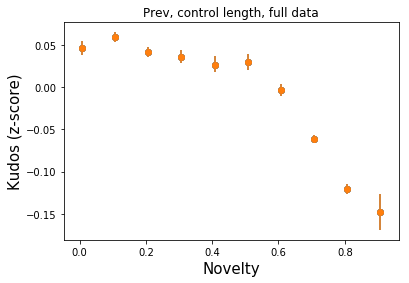

In [12]:
plot_agg(fandom_list, 'Prev, control length, full data')

In [26]:
dic1 = {0.07306596877841331: (0.10051092067956448, 0.09230688109665527, 0.10949622538494314), 0.17306596877841332: (0.06278218097722164, 0.057723352384369396, 0.06815467678199578), 0.2730659687784133: (0.03634496427997151, 0.030251504313672774, 0.04240588370574836), 0.37306596877841336: (0.01829212230353787, 0.010665221172694861, 0.026433932734677926), 0.47306596877841334: (-0.0013918303410280384, -0.00978319762179942, 0.006764918205032788), 0.5730659687784133: (-0.013820107316660174, -0.023368819138610948, -0.004416051048604686), 0.6730659687784134: (0.0020549882975858026, -0.006017930421751201, 0.010508243858324804), 0.7730659687784134: (-0.034654355801952835, -0.039491208719540434, -0.02965666083240206), 0.8730659687784134: (-0.10805178546657561, -0.11261318038542459, -0.10374071415483743), 0.9730659687784133: (-0.18619850464611035, -0.23718588361637352, -0.12860422421774106)}

In [29]:
dic2 = {0.3183411357554178: (0.24241465042484875, -0.006164701759626134, 0.5944718796431884), 0.36834113575541777: (0.22673578073694903, 0.15390811153868425, 0.30398280703288255), 0.41834113575541776: (0.14370523271634691, 0.12231307608458984, 0.16592279293653225), 0.46834113575541775: (0.09697002741735164, 0.08754993897590656, 0.10716537785241802), 0.5183411357554177: (0.05028840368030578, 0.04462646819885872, 0.05582556567387392), 0.5683411357554178: (-0.010889868000214827, -0.014638593609687596, -0.007197468435968111), 0.6183411357554177: (-0.03850769421516654, -0.041846794112008416, -0.035295115928653975), 0.6683411357554176: (0.03276530976037038, 0.0003204398026430979, 0.06694657868733242)}

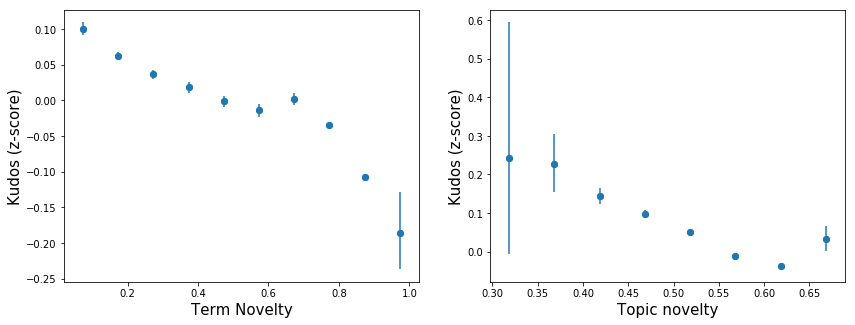

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)

x1 = sorted(dic1.keys())
y1 = [dic1[j][0] for j in x1]

lower_error = [dic1[j][0]-dic1[j][1] for j in x1]
upper_error = [dic1[j][2]-dic1[j][0] for j in x1]
asymmetric_error = [lower_error, upper_error]

plt.errorbar(x1, y1, yerr=asymmetric_error,fmt='o')
plt.scatter(x1, y1)
plt.xlabel('Term Novelty',fontsize=15)
plt.ylabel('Kudos (z-score)',fontsize=15)

plt.subplot(1, 2, 2)

x2 = sorted(dic2.keys())
y2 = [dic2[j][0] for j in x2]

lower_error = [dic2[j][0]-dic2[j][1] for j in x2]
upper_error = [dic2[j][2]-dic2[j][0] for j in x2]
asymmetric_error = [lower_error, upper_error]

plt.errorbar(x2, y2, yerr=asymmetric_error,fmt='o')
plt.scatter(x2, y2)
plt.xlabel('Topic novelty',fontsize=15)
plt.ylabel('Kudos (z-score)',fontsize=15)

plt.savefig('novelty_comments_tfidf_lda.pdf', type='pdf')

